In [205]:
from utils import*
import scipy.io as sio



In [209]:
####################################################################################################################################################
class NODE(object):
    ################################################################################################################################################
    def __init__(self, markers_color, IDD=None, port=None):
        self.markers_color = markers_color
        self.IDD = IDD
        self.port = port
    ################################################################################################################################################
    def get_data(self, dataset_name, file_name, ref_node=None, window_length=11, ref_node_data=None, full_motion_data=False):        
        
        data = self.get_motion(dataset_name, file_name, window_length=window_length, ref_node_data=ref_node_data, full_motion_data=full_motion_data)  
        time = data.time    # use kinect time as ref time

        if self.IDD is not None: 
            rssi = self.get_rssi(dataset_name, file_name, window_length=window_length)
            data = data.merge( rssi, on='time', how='outer', suffixes=('', ''), sort=True)            
            # t_start, t_end = max(t_start, rssi.time.iloc[0]), min(t_end,  rssi.time.iloc[-1])
            time = time.loc[time> rssi.time.iloc[0]].loc[time< rssi.time.iloc[-1]]

        if self.port is not None: 
            vind = self.get_vind(dataset_name, file_name, window_length=window_length)
            data = data.merge( vind, on='time', how='outer', suffixes=('', ''), sort=True)
            # t_start, t_end = max(t_start, vind.time.iloc[0]), min(t_end,  vind.time.iloc[-1])
            time = time.loc[time> vind.time.iloc[0]].loc[time< vind.time.iloc[-1]]
        
        data.interpolate(method='nearest', axis=0, inplace=True)      
        data = pd.merge( pd.DataFrame(time), data, on='time', how='inner', suffixes=('', ''), sort=True)

        return data
    ################################################################################################################################################
    def get_motion(self, dataset_name, file_name, window_length=11, ref_node_data=None, full_motion_data=False):   
        markers_file_path = get_markers_file_path(dataset_name, file_name)  
        raw_df  = pd.read_csv(
            markers_file_path,                                                  # relative python path to subdirectory
            usecols = ['time', self.markers_color],                             # Only load the three columns specified.
            parse_dates = ['time'] )         

        # Time
        date_time = pd.to_datetime( raw_df['time'] , format=datime_format)
        time = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
        
        # Markers
        markers = [list(map(float, l.replace(']','').replace('[','').replace('\n','').split(", "))) for l in raw_df[self.markers_color].values]  
        markers_npy = np.array(markers).reshape(len(time), -1, 3)
        # DON'T Smooth markers. markers can be switched in array and smoothing causes error    

        # Center    
        center = np.mean(markers_npy, axis=1)         
        center = np.nan_to_num(center)
        center = signal.savgol_filter( center, window_length=window_length, polyorder=1, axis=0)     

        # Norm
        norm = np.cross( markers_npy[:,1,:] - markers_npy[:,0,:], markers_npy[:,2,:] - markers_npy[:,0,:])
        # norm[ norm[:,2]<0, :] *= -1   # Don't use ! 
        norm = norm / ( np.reshape(np.linalg.norm(norm, axis=1), (-1,1)) * np.ones((1,3)))
        # DOn't smooth norm 

        if ref_node_data is None:            
            return pd.DataFrame({
                'time': time,
                'markers': markers,
                'center': list(center), 
                'norm': list(norm)
                })    

        ############################
        #### Relative Movements ####

        # Reader center/norm     
        N = 10
        ref_center = np.tile( np.mean(ref_node_data.center.loc[:N], axis=0), (len(ref_node_data),1) )
        ref_norm = np.tile( np.mean(ref_node_data.norm.loc[:N], axis=0), (len(ref_node_data),1) )            
        
        distance_vec = ref_center - center                                                                  # Distance (vector)        
        distance = np.linalg.norm( distance_vec, axis=1)                                                    # Distance
        lat_misalignment = np.sqrt(distance**2 - np.sum(np.multiply( distance_vec, ref_norm), axis=1)**2)   # Lateral Misalignment                   
        ang_misalignment = np.arcsin( np.linalg.norm(np.cross(ref_norm, norm), axis=1) )*180/np.pi          # Angular Misalignment

        # Smoothing (smooth these params after all calculation)               
        distance = signal.savgol_filter( distance, window_length=window_length, polyorder=1, axis=0)                        
        lat_misalignment = signal.savgol_filter( lat_misalignment, window_length=window_length, polyorder=1, axis=0)        
        ang_misalignment = signal.savgol_filter( ang_misalignment, window_length=window_length, polyorder=1, axis=0)  

        if full_motion_data:
            return pd.DataFrame({
                'time': time,
                'markers': markers,
                'center': list(center), 
                'norm': list(norm),
                'distance': list(distance),
                'lat_misalignment': list(lat_misalignment),
                'ang_misalignment': list(ang_misalignment)
                })       
        else:
            return pd.DataFrame({
                'time': time,
                'distance': list(distance),
                'lat_misalignment': list(lat_misalignment),
                'ang_misalignment': list(ang_misalignment)
                })                      
    ################################################################################################################################################
    def get_rssi(self, dataset_name, file_name, window_length=11):
        # Load data 
        rfid_file_path = get_rfid_file_path(dataset_name, file_name)       
        raw_df = pd.read_csv(
            rfid_file_path,                                                     # relative python path to subdirectory
            delimiter  = ';',                                                   # Tab-separated value file.
            usecols = ['IDD', 'Time', 'Ant/RSSI'],                              # Only load the three columns specified.
            parse_dates = ['Time'] )                                            # Intepret the birth_date column as a date      
        raw_df = raw_df.loc[ raw_df['IDD'] == self.IDD, :]

        # Time
        date_time = pd.to_datetime( raw_df['Time'] , format=datime_format)
        time = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
        
        # RSSI
        # rssi_df = pd.DataFrame({ 'rssi': raw_df['Ant/RSSI'].str.replace('Ant.No 1 - RSSI: ', '').astype(int) })
        rssi_df = raw_df['Ant/RSSI'].str.replace('Ant.No 1 - RSSI: ', '').astype(float) 
        rssi_df = rssi_df.rolling(window_length, axis=0).median()   # Smoothing
        rssi_df = rssi_df.ffill(axis=0).bfill(axis=0)               # Gap Filling

        return pd.DataFrame({
            'time':time,
            'rssi':rssi_df.tolist() 
            })
    ################################################################################################################################################
    def get_vind(self, dataset_name, file_name, window_length=11):
        # Load data 
        arduino_file_path = get_arduino_file_path(dataset_name, file_name)               
        raw_df = pd.read_csv(arduino_file_path)
        raw_df = raw_df.loc[ raw_df['port'] == self.port, :]

        # Time
        date_time = pd.to_datetime( raw_df['time'] , format=datime_format)
        time = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
        
        # RSSI
        # rssi_df = pd.DataFrame({ 'rssi': raw_df['Ant/RSSI'].str.replace('Ant.No 1 - RSSI: ', '').astype(int) })
        vind_df = raw_df['vind'].astype(float) 
        vind_df = vind_df.rolling(window_length, axis=0).median()   # Smoothing
        vind_df = vind_df.ffill(axis=0).bfill(axis=0)               # Gap Filling

        return pd.DataFrame({
            'time':time,
            'vind':vind_df.tolist() 
            })
########################################################################################################################################################################################################################################################################################################
class SYSTEM(object):
    ################################################################################################################################################
    def __init__(self, system_info = None):
        self.reader = None
        self.tags = list()

        if system_info is not None:
            
            for idx in sys_info.index:                
                node_info = sys_info.loc[idx, sys_info.columns!='type'].to_dict()                
                for key,value in node_info.items():
                    if value == 'None': node_info.update({key: None})
                
                node = NODE( **node_info )
                if sys_info.loc[idx, 'type'] == 'tag': self.tags.append(node)
                else: self.reader = node
        return
    ################################################################################################################################################
    def add_reader(self, reader_markers_color):
        self.reader = NODE( reader_markers_color )
        return
    ################################################################################################################################################
    def add_tag(self, markers_color, IDD=None, port=None):
        self.tags.append( NODE(markers_color, IDD=IDD, port=port) )   
        return               
    ################################################################################################################################################
    def get_data(self, dataset_name, file_name, save=False, window_length=11):
        reader_data = self.reader.get_data(dataset_name, file_name)  
        data = pd.DataFrame({'time':reader_data.time})

        for i, tag in enumerate(self.tags):
            tag_data = tag.get_data(dataset_name, file_name, ref_node_data=reader_data)
            tag_data = tag_data.add_suffix('_'+str(i)).rename({'time_'+str(i):'time'}, axis='columns')
            data = data.merge( tag_data, on='time', how='outer', suffixes=('', '' ), sort=True )

        data.interpolate(method='nearest', inplace=True)  
        data.time -= data.time.loc[0]    

        # # Select specific time samples 
        # if self.tags[0].IDD is not None: input_data_type = 'rssi'
        # elif self.tags[0].port is not None: input_data_type = 'vind'        
        # target_time = data.time[ np.where(np.any( ~np.isnan(data.filter(regex=input_data_type, axis=1)), axis=1))[0] ]   # time samples that at least one rssi/vind is not Nan
        
        # data.interpolate(method='nearest', inplace=True)  
        # data.loc[:, data.columns!='time'] = data.loc[:, data.columns!='time'].rolling(window_length, axis=0).mean().fillna(method='ffill', axis=0).bfill(axis=0)      
        # data = data.merge( pd.DataFrame({'time':target_time}), on='time', how='inner', suffixes=('', '' ), sort=True )
     
        # Save
        if save:
            dataset_file_path = get_dataset_file_path(dataset_name, file_name)
            create_folder(dataset_file_path)
            data.to_pickle( dataset_file_path)  
            print(file_name, 'is saved.')

        return data
####################################################################################################################################################


In [211]:
dataset_name = 'dataset_05'    
sys_info = get_sys_info(dataset_name)    
sys = SYSTEM(system_info=sys_info)

for n in range(30):
    file_name = 'record_' + "{0:0=2d}".format(n)
    data = sys.reader.get_data(dataset_name, file_name)  

    for i, tag in enumerate(sys.tags):
        tag_data = tag.get_data(dataset_name, file_name, ref_node_data=data, full_motion_data=True)
        tag_data = tag_data.add_suffix('_'+str(i)).rename({'time_'+str(i):'time'}, axis='columns')
        data = data.merge( tag_data, on='time', how='outer', suffixes=('', '' ), sort=True )

    data.interpolate(method='nearest', inplace=True)  
    data.time -= data.time.loc[0]    

    sio.savemat( '../' + dataset_name + '/' + file_name +'.mat', {name: col.values for name, col in data.items()}) 


0
1


ValueError: operands could not be broadcast together with shapes (437,3) (364,3) 

In [127]:
dataset_name = 'dataset_05'   
file_name = 'record_' + "{0:0=2d}".format(0)
port = '/dev/cu.usbserial-1410'
window_length = 11

# Load data 
arduino_file_path = get_arduino_file_path(dataset_name, file_name)               
raw_df = pd.read_csv(arduino_file_path)
raw_df = raw_df.loc[ raw_df['port'] == port, :]

# Time
date_time = pd.to_datetime( raw_df['time'] , format=datime_format)
time = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]

# RSSI
# rssi_df = pd.DataFrame({ 'rssi': raw_df['Ant/RSSI'].str.replace('Ant.No 1 - RSSI: ', '').astype(int) })
vind_df = raw_df['vind'].astype(float) 
vind_df = vind_df.rolling(window_length, axis=0).median()   # Smoothing
vind_df = vind_df.ffill(axis=0).bfill(axis=0)            

In [128]:

dataset_name = 'dataset_05'    
sys_info = get_sys_info(dataset_name)    
sys = SYSTEM(system_info=sys_info)

In [132]:
reader_data = sys.reader.get_data(dataset_name, file_name)

motion_data = sys.tags[0].get_motion(dataset_name, file_name, ref_node_data=reader_data)
vind_data = sys.tags[0].get_vind(dataset_name, file_name)

data = sys.get_data(dataset_name, file_name)


In [190]:
data_ = pd.merge( motion_data, vind_data, on='time', how='outer', suffixes=('', ''), sort=True)
# data = vind_data.merge( motion_data, on='time', how='outer', suffixes=('', ''), sort=True)

In [200]:
time = data_.time

time.loc[time>45420].loc[time<45440]

761     45420.01
762     45420.02
763     45420.03
764     45420.04
765     45420.05
          ...   
2755    45439.95
2756    45439.96
2757    45439.97
2758    45439.98
2759    45439.99
Name: time, Length: 1999, dtype: float64

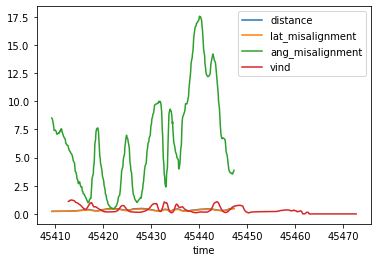

In [154]:
ax = motion_data.plot(x='time')
vind_data.plot(x'time', ax=ax)

In [192]:
data = data_.loc[ 45420<data_.time, :].loc[ data_.time<45440, :]
data

,time,markers,center,norm,distance,lat_misalignment,ang_misalignment,vind
761,45420.01,NaN,NaN,NaN,NaN,NaN,NaN,0.234375
762,45420.02,NaN,NaN,NaN,NaN,NaN,NaN,0.234375
763,45420.03,"[0.14098854, 0.08195475, 0.96300006, 0.1502684...","[0.17150906060606055, 0.13121738709090905, 0.9...","[0.02380453781649924, 0.16445906472095953, -0....",0.381857,0.350718,3.099715,0.234375
764,45420.04,NaN,NaN,NaN,NaN,NaN,NaN,0.234375
765,45420.05,NaN,NaN,NaN,NaN,NaN,NaN,0.229492
...,...,...,...,...,...,...,...,...
2755,45439.95,NaN,NaN,NaN,NaN,NaN,NaN,0.156250
2756,45439.96,NaN,NaN,NaN,NaN,NaN,NaN,0.156250
2757,45439.97,NaN,NaN,NaN,NaN,NaN,NaN,0.151367
2758,45439.98,"[0.12332302, 0.10425252, 0.97200006, 0.1089694...","[0.1358117362424242, 0.15981694309090907, 0.95...","[-0.5684338283004771, -0.1250573154414771, -0....",0.394267,0.357427,17.261951,0.156250


In [37]:
import scipy.io as sio
sio.savemat(os.path.join(destination_folder_path,'meta.mat'), df)

{'markers_color': 'red', 'IDD': None, 'port': None}

In [47]:
# dataset_name = 'dataset_00'

# time_folder_path = main_directory + '/dataset/' + dataset_name + '/kinect/time'
# markers_folder_path = main_directory + '/dataset/' + dataset_name + '/kinect/markers'

# for n in range(30):
#     file_name = 'record_' + "{0:0=2d}".format(n)
    
#     time_file_path = time_folder_path + '/' + file_name + '.txt'   
#     with open(time_file_path , 'r') as f:  lines = f.read().splitlines() 
#     date_time = pd.to_datetime( lines , format=datime_format)
#     time = pd.DataFrame({'time':[t.time() for t in date_time]})
             
#     locations_dict_ = dict()
#     for color in ['red','blue','green']:
#         markers_file_path = markers_folder_path + '/' + file_name + '_' + color +'.txt' 
#         locations = pd.read_csv( markers_file_path, delimiter="\t", header=None, dtype=np.float64).to_numpy()
# #         locations_dict_.update({color: locations})
#         locations_dict_.update({color: list(map(list,locations))})
    
#     locations_dict = defaultdict(list)  
#     for l in range(len(time)):
#         for color in ['red','blue','green']:
#             locations_dict[color].append( locations_dict_[color][l] )                            

#   # MArkers (time and locations)
#     markers = pd.concat([time, pd.DataFrame(locations_dict)], axis=1)

#     # Save 
#     markers_file_path = get_markers_file_path(dataset_name, file_name)
#     create_folder(markers_file_path)
#     markers.to_csv(markers_file_path, index=False)
        